In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.out = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x) # logits out!
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc1): Linear(in_features=784, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=50, bias=True)
    (out): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [2]:
def pgd_linf_untargeted(model, x, labels, k, eps, eps_step):
    # model.eval()
    ce_loss = torch.nn.CrossEntropyLoss()
    adv_x = x.clone().detach()
    adv_x.requires_grad_(True) 
    for _ in range(k):
        adv_x.requires_grad_(True)
        model.zero_grad()
        output = model(adv_x)
        # TODO: Calculate the loss
        loss = ce_loss(output, labels)
        loss.backward()
        # TODO: compute the adv_x
        # find delta, clamp with eps          
        delta = torch.clamp(adv_x + eps_step * adv_x.grad.sign() - x.data, min=-eps, max=eps)
        adv_x = torch.clamp(x.data + delta, min=0, max=1).detach_()
   
    return adv_x

def pgd_l2_untargeted(model, x, labels, k, eps, eps_step):
    # model.eval()
    ce_loss = torch.nn.CrossEntropyLoss()
    adv_x = x.clone().detach()
    adv_x.requires_grad_(True) 
    for _ in range(k):
        adv_x.requires_grad_(True)
        model.zero_grad()
        output = model(adv_x)
        batch_size = x.size()[0]
        # TODO: Calculate the loss
        loss = ce_loss(output, labels)
        loss.backward()
        grad = adv_x.grad.data
        # TODO: compute the adv_x
        # find delta, clamp with eps, project delta to the l2 ball
        # HINT: https://github.com/Harry24k/adversarial-attacks-pytorch/blob/master/torchattacks/attacks/pgdl2.py
        eps_for_division = 1e-10
        grad_norms = (
            torch.norm(grad.view(batch_size, -1), p=2, dim=1)
            + eps_for_division
        )  # nopep8
        grad = grad / grad_norms.view(batch_size, 1, 1, 1)
        adv_x = adv_x.detach() + eps_step * grad
        
        delta = adv_x  - x.data
        delta_norms = torch.norm(delta.view(batch_size, -1), p=2, dim=1)
        factor = eps / delta_norms
        factor = torch.min(factor, torch.ones_like(delta_norms))
        delta = delta * factor.view(-1, 1, 1, 1)
        
        adv_x = torch.clamp(x.data + delta, min=0, max=1).detach_()
   
    return adv_x

In [3]:
def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        # tbar = tqdm(total=len(test_loader), desc="items of test:")
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        #     tbar.update(1)
        # tbar.close()
        print(f'Accuracy on images: {100 * correct / total}')

def test_model_robust(model, attack='pgd', eps=8/255, k=10):
    model.eval()
    # with torch.no_grad():abs
    correct = 0
    total = 0
    # tbar = tqdm(total=len(test_loader), desc="items of test:")
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        if attack == 'fgsm':
            adv_images = pgd_linf_untargeted(model, images, labels, k=1, eps=eps, eps_step=eps)
        else:  # pgd
            adv_images = pgd_linf_untargeted(model, images, labels, k=k, eps=eps, eps_step=eps/4)
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    #     tbar.update(1)
    # tbar.close()
    print(f'Accuracy on images: {100 * correct / total}')



In [4]:
from tqdm import tqdm

def train_model_ibp(model, num_epochs, eps_target=0.1, k_start=1.0, k_end=0.5):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        # gradual schedules for k and eps
        k = k_start + (k_end - k_start) * (epoch / max(num_epochs - 1, 1))
        eps_train = eps_target * (epoch / max(num_epochs - 1, 1))

        # tbar = tqdm(total=len(train_loader), desc="items of one epoch:")
        for i, data in enumerate(train_loader, 0):
            print(f"{i}/{len(train_loader)}", end="\r")
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # forward
            outputs = model(images)
            l = torch.clamp(images - eps_train, 0.0, 1.0)
            u = torch.clamp(images + eps_train, 0.0, 1.0)
            l = (l - 0.1307) / 0.3081
            u = (u - 0.1307) / 0.3081
            B = images.size(0)
            l = l.view(B, -1)
            u = u.view(B, -1)
            net = model[1]

            # fc1 relu
            W, b = net.fc1.weight, net.fc1.bias
            Wp, Wn = torch.clamp(W, min=0), torch.clamp(W, max=0)
            lo = l @ Wp.t() + u @ Wn.t() + b
            hi = u @ Wp.t() + l @ Wn.t() + b
            l, u = F.relu(lo), F.relu(hi)

            # fc2 relu
            W, b = net.fc2.weight, net.fc2.bias
            Wp, Wn = torch.clamp(W, min=0), torch.clamp(W, max=0)
            lo = l @ Wp.t() + u @ Wn.t() + b
            hi = u @ Wp.t() + l @ Wn.t() + b
            l, u = F.relu(lo), F.relu(hi)

            # fc3 relu
            W, b = net.fc3.weight, net.fc3.bias
            Wp, Wn = torch.clamp(W, min=0), torch.clamp(W, max=0)
            lo = l @ Wp.t() + u @ Wn.t() + b
            hi = u @ Wp.t() + l @ Wn.t() + b
            l, u = F.relu(lo), F.relu(hi)

            # out layer (logits)
            W, b = net.out.weight, net.out.bias
            Wp, Wn = torch.clamp(W, min=0), torch.clamp(W, max=0)
            lo = l @ Wp.t() + u @ Wn.t() + b
            hi = u @ Wp.t() + l @ Wn.t() + b
            l, u = lo, hi

            # pessimistic logits
            logits_hat = u.clone()
            idx = torch.arange(labels.size(0), device=labels.device)
            logits_hat[idx, labels] = l[idx, labels]
            loss = k * criterion(outputs, labels) + (1.0 - k) * criterion(logits_hat, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        #     tbar.update(1)
        # tbar.close()
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, k={k:.3f}, eps_train={eps_train:.3f}, Loss: {running_loss/len(train_loader):.3f}')


In [5]:
model = nn.Sequential(Normalize(), Net()).to(device)
train_model_ibp(model, num_epochs=5, eps_target=0.1, k_start=1.0, k_end=0.5)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [03:20<13:21, 200.48s/it]

Epoch 1/5, k=1.000, eps_train=0.000, Loss: 0.423


 40%|████      | 2/5 [06:56<10:29, 209.79s/it]

Epoch 2/5, k=0.875, eps_train=0.025, Loss: 0.297


 60%|██████    | 3/5 [11:11<07:40, 230.48s/it]

Epoch 3/5, k=0.750, eps_train=0.050, Loss: 0.370


 80%|████████  | 4/5 [15:09<03:53, 233.41s/it]

Epoch 4/5, k=0.625, eps_train=0.075, Loss: 0.510


100%|██████████| 5/5 [18:43<00:00, 224.72s/it]

Epoch 5/5, k=0.500, eps_train=0.100, Loss: 0.730


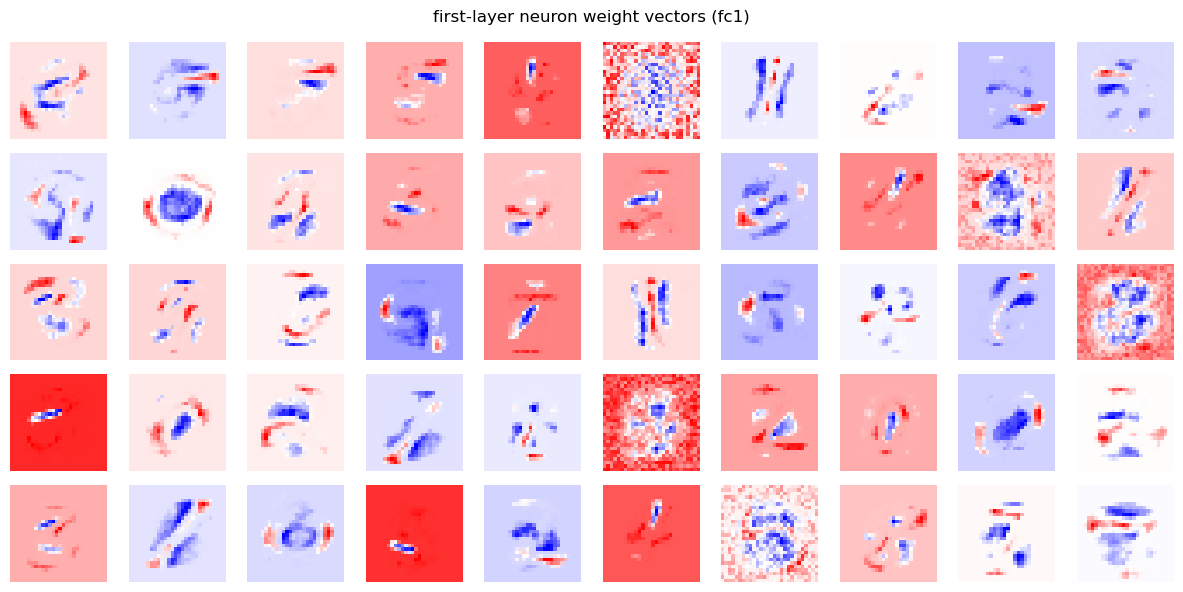

In [13]:

# for homework 5
import numpy as np
import matplotlib.pyplot as plt

W = model[1].fc1.weight.detach().cpu().numpy()

fig, axs = plt.subplots(5, 10, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(W[i].reshape(28, 28), cmap="bwr")
    ax.axis("off")

plt.suptitle("first-layer neuron weight vectors (fc1)")
plt.tight_layout()
plt.savefig("cs521_hw5_5.png")
plt.show()


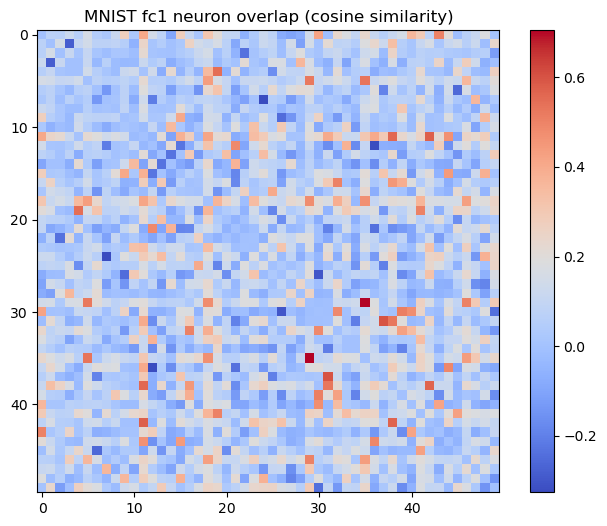

In [14]:


W = model[1].fc1.weight.detach().cpu().numpy()
Wn = W / (np.linalg.norm(W, axis=1, keepdims=True) + 1e-8)

WtW = Wn @ Wn.T
np.fill_diagonal(WtW, 0)

plt.figure(figsize=(8,6))
plt.imshow(WtW, cmap="coolwarm")
plt.colorbar()
plt.title("MNIST fc1 neuron overlap (cosine similarity)")
plt.savefig("cs521_hw5_6.png")
plt.show()